In [3]:
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
from functools import reduce
import numpy as np
import libpysal as lps
import seaborn as sns
import libpysal as lps
import pysal as ps
from libpysal.weights import Queen, Rook, KNN
from shapely import wkt
from scipy.spatial import cKDTree
import sklearn.model_selection as model_select
from math import sqrt
from sklearn import metrics
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.neural_network import MLPRegressor
from libpysal import weights
try:
    from scipy.optimize import minimize_scalar
    minimize_scalar_available = True
except ImportError:
    minimize_scalar_available = False
import warnings
warnings.simplefilter('ignore')

In [4]:
pd.set_option('display.max_rows', 1000)

In [5]:
#maize residue
maize18=pd.read_csv("dataset/production/Maize_2018.csv",usecols=["Area Code (FAO)","Maize_Residue"])

In [6]:
#read country code
country_code=pd.read_csv("dataset/country_data.csv",usecols=["Country Code","Country","ISO2 Code","ISO3 Code"])
country_code.head()

Country Code         Country ISO2 Code ISO3 Code
0             2     Afghanistan        AF       AFG
1          5100          Africa       NaN       X06
2             3         Albania        AL       ALB
3             4         Algeria        DZ       DZA
4             5  American Samoa        AS       ASM

In [7]:
#country area
area=pd.read_csv("dataset/cropland/country_area.csv",usecols=["country_area","ISO3 Code"])
area.head()

ISO3 Code  country_area
0       ABW         180.0
1       AFG      652860.0
2       AGO     1246700.0
3       ALB       28750.0
4       AND         470.0

In [8]:
#read shapefile
poly=gpd.read_file("dataset/wb_countries_admin0_10m/wb_countries_admin0_10m.shp")
poly.columns

Index(['OBJECTID', 'featurecla', 'LEVEL', 'TYPE', 'FORMAL_EN', 'FORMAL_FR',
       'POP_EST', 'POP_RANK', 'GDP_MD_EST', 'POP_YEAR', 'LASTCENSUS',
       'GDP_YEAR', 'ECONOMY', 'INCOME_GRP', 'FIPS_10_', 'ISO_A2', 'ISO_A3',
       'ISO_A3_EH', 'ISO_N3', 'UN_A3', 'WB_A2', 'WB_A3', 'CONTINENT',
       'REGION_UN', 'SUBREGION', 'REGION_WB', 'NAME_AR', 'NAME_BN', 'NAME_DE',
       'NAME_EN', 'NAME_ES', 'NAME_FR', 'NAME_EL', 'NAME_HI', 'NAME_HU',
       'NAME_ID', 'NAME_IT', 'NAME_JA', 'NAME_KO', 'NAME_NL', 'NAME_PL',
       'NAME_PT', 'NAME_RU', 'NAME_SV', 'NAME_TR', 'NAME_VI', 'NAME_ZH',
       'WB_NAME', 'WB_RULES', 'WB_REGION', 'Shape_Leng', 'Shape_Area',
       'geometry'],
      dtype='object')

In [9]:
poly.loc[50,"ISO_A3_EH"]="NOR"

In [10]:
#merge country code and shapefile
country_poly=pd.merge(country_code,poly,left_on="ISO3 Code",right_on="ISO_A3_EH",how="inner")

In [11]:
country_poly1=pd.merge(country_poly,area,on="ISO3 Code",how="outer")
country_poly1

Country Code                                            Country  \
0               2                                        Afghanistan   
1               3                                            Albania   
2               4                                            Algeria   
3               5                                     American Samoa   
4               6                                            Andorra   
5               7                                             Angola   
6             258                                           Anguilla   
7               8                                Antigua and Barbuda   
8               9                                          Argentina   
9               1                                            Armenia   
10             22                                              Aruba   
11             10                                          Australia   
12             11                                            Austria   
13             52                                         Azerbaijan   
14             12                                            Bahamas   
15             13                                            Bahrain   
16             16                                         Bangladesh   
17             14                                           Barbados   
18             57                                            Belarus   
19            255                                            Belgium   
20             23                                             Belize   
21             53                                              Benin   
22             17                                            Bermuda   
23             18                                             Bhutan   
24             19                   Bolivia (Plurinational State of)   
25             80                             Bosnia and Herzegovina   
26             20                                           Botswana   
27             21                                             Brazil   
28            239                             British Virgin Islands   
29             26                                  Brunei Darussalam   
30             27                                           Bulgaria   
31            233                                       Burkina Faso   
32             29                                            Burundi   
33             35                                         Cabo Verde   
34            115                                           Cambodia   
35             32                                           Cameroon   
36             33                                             Canada   
37             36                                     Cayman Islands   
38             37                           Central African Republic   
39             39                                               Chad   
40             40                                              Chile   
41            351                                              China   
42             96                               China, Hong Kong SAR   
43            128                                   China, Macao SAR   
44             44                                           Colombia   
45             45                                            Comoros   
46             46                                              Congo   
47             47                                       Cook Islands   
48             48                                         Costa Rica   
49            107                                      Côte d'Ivoire   
50             98                                            Croatia   
51             49                                               Cuba   
52             50                                             Cyprus   
53            167                                            Czechia   
54            116              Democratic Peo

In [12]:
#select columns
country_poly1=pd.DataFrame(country_poly1,columns=["Country Code","Country","geometry","CONTINENT","country_area"])
country_poly1

Country Code                                            Country  \
0               2                                        Afghanistan   
1               3                                            Albania   
2               4                                            Algeria   
3               5                                     American Samoa   
4               6                                            Andorra   
5               7                                             Angola   
6             258                                           Anguilla   
7               8                                Antigua and Barbuda   
8               9                                          Argentina   
9               1                                            Armenia   
10             22                                              Aruba   
11             10                                          Australia   
12             11                                            Austria   
13             52                                         Azerbaijan   
14             12                                            Bahamas   
15             13                                            Bahrain   
16             16                                         Bangladesh   
17             14                                           Barbados   
18             57                                            Belarus   
19            255                                            Belgium   
20             23                                             Belize   
21             53                                              Benin   
22             17                                            Bermuda   
23             18                                             Bhutan   
24             19                   Bolivia (Plurinational State of)   
25             80                             Bosnia and Herzegovina   
26             20                                           Botswana   
27             21                                             Brazil   
28            239                             British Virgin Islands   
29             26                                  Brunei Darussalam   
30             27                                           Bulgaria   
31            233                                       Burkina Faso   
32             29                                            Burundi   
33             35                                         Cabo Verde   
34            115                                           Cambodia   
35             32                                           Cameroon   
36             33                                             Canada   
37             36                                     Cayman Islands   
38             37                           Central African Republic   
39             39                                               Chad   
40             40                                              Chile   
41            351                                              China   
42             96                               China, Hong Kong SAR   
43            128                                   China, Macao SAR   
44             44                                           Colombia   
45             45                                            Comoros   
46             46                                              Congo   
47             47                                       Cook Islands   
48             48                                         Costa Rica   
49            107                                      Côte d'Ivoire   
50             98                                            Croatia   
51             49                                               Cuba   
52             50                                             Cyprus   
53            167                                            Czechia   
54            116              Democratic Peo

In [13]:
# merge maize and country polygon data
maize18_g=pd.merge(country_poly1,maize18,left_on="Country Code",right_on="Area Code (FAO)",how="outer")
maize18_g=gpd.GeoDataFrame(maize18_g)

In [14]:
maize18_g

Country Code                                            Country  \
0             2.0                                        Afghanistan   
1             3.0                                            Albania   
2             4.0                                            Algeria   
3             5.0                                     American Samoa   
4             6.0                                            Andorra   
5             7.0                                             Angola   
6           258.0                                           Anguilla   
7             8.0                                Antigua and Barbuda   
8             9.0                                          Argentina   
9             1.0                                            Armenia   
10           22.0                                              Aruba   
11           10.0                                          Australia   
12           11.0                                            Austria   
13           52.0                                         Azerbaijan   
14           12.0                                            Bahamas   
15           13.0                                            Bahrain   
16           16.0                                         Bangladesh   
17           14.0                                           Barbados   
18           57.0                                            Belarus   
19          255.0                                            Belgium   
20           23.0                                             Belize   
21           53.0                                              Benin   
22           17.0                                            Bermuda   
23           18.0                                             Bhutan   
24           19.0                   Bolivia (Plurinational State of)   
25           80.0                             Bosnia and Herzegovina   
26           20.0                                           Botswana   
27           21.0                                             Brazil   
28          239.0                             British Virgin Islands   
29           26.0                                  Brunei Darussalam   
30           27.0                                           Bulgaria   
31          233.0                                       Burkina Faso   
32           29.0                                            Burundi   
33           35.0                                         Cabo Verde   
34          115.0                                           Cambodia   
35           32.0                                           Cameroon   
36           33.0                                             Canada   
37           36.0                                     Cayman Islands   
38           37.0                           Central African Republic   
39           39.0                                               Chad   
40           40.0                                              Chile   
41          351.0                                              China   
42           96.0                               China, Hong Kong SAR   
43          128.0                                   China, Macao SAR   
44           44.0                                           Colombia   
45           45.0                                            Comoros   
46           46.0                                              Congo   
47           47.0                                       Cook Islands   
48           48.0                                         Costa Rica   
49          107.0                                      Côte d'Ivoire   
50           98.0                                            Croatia   
51           49.0                                               Cuba   
52           50.0                                             Cyprus   
53          167.0                                            Czechia   
54          116.0              Democratic Peo

In [15]:
maize18_g=maize18_g.drop([227,228])

Text(0.5, 1, 'Barley Residues (2018)')

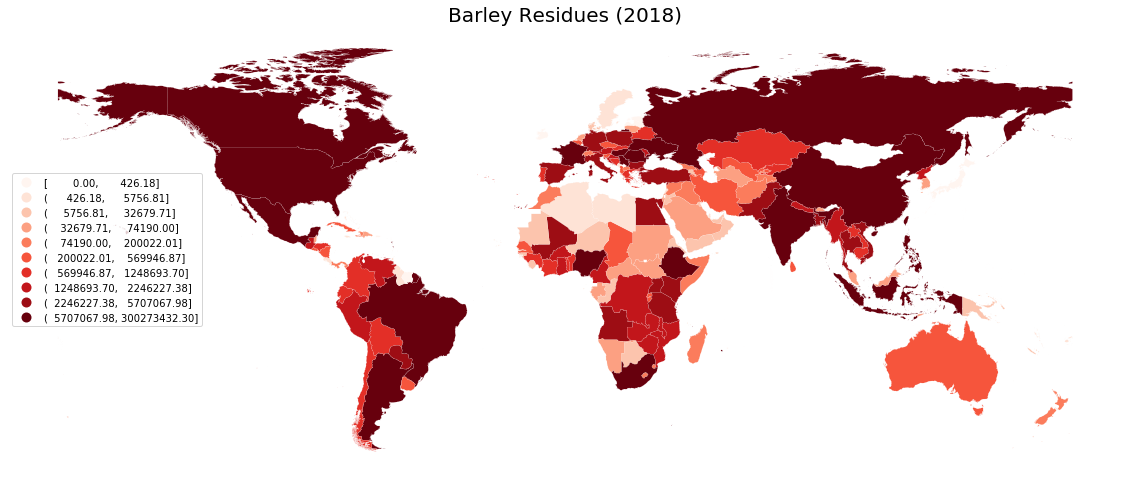

In [16]:
#visualize
fig, ax = plt.subplots(figsize=(20, 15))
#barley17_g.plot(column='barley_value', missing_kwds={'color': 'lightgrey'})
maize18_g.plot(column='Maize_Residue',scheme='quantiles',k=10, 
         cmap=plt.cm.Reds, alpha=1, legend=True,legend_kwds=dict(loc='center left'),
         edgecolor='w', linewidth=0.1,ax=ax,
               
       )
ax.set_axis_off()
ax.set_title("Barley Residues (2018)", fontsize=20)

In [17]:
#fill missing values of Maize residue

In [18]:
#get centriod of each polygon
maize18_g["centroid"]=maize18_g["geometry"].values.centroid
missing_index=maize18_g[np.isnan(maize18_g["Maize_Residue"].values)].index

In [19]:
def ckdnearest(gdA,missing):    
    nA = np.array(list(gdA.centroid.apply(lambda x: (x.x, x.y))))
    btree = cKDTree(nA)
    for i in missing:
        nB=np.array(list([maize18_g.loc[i,"centroid"].x,maize18_g.loc[i,"centroid"].y]))
        dist, idx = btree.query(nB, k=4)
        sum_r=0
        k=0
        for j in idx:
            if not np.isnan(maize18_g.loc[j,"Maize_Residue"]):
                k=k+1
                sum_r=sum_r+maize18_g.loc[j,"Maize_Residue"]
        if k!=0:
            a_sum=sum_r/k
            maize18_g.loc[i,"Maize_Residue"]=a_sum

while len(maize18_g[np.isnan(maize18_g["Maize_Residue"].values)].index)!=0:
    ckdnearest(maize18_g,maize18_g[np.isnan(maize18_g["Maize_Residue"].values)].index)

In [20]:
len(maize18_g[np.isnan(maize18_g["Maize_Residue"].values)])

0

Text(0.5, 1, 'Maize Residues (2018)')

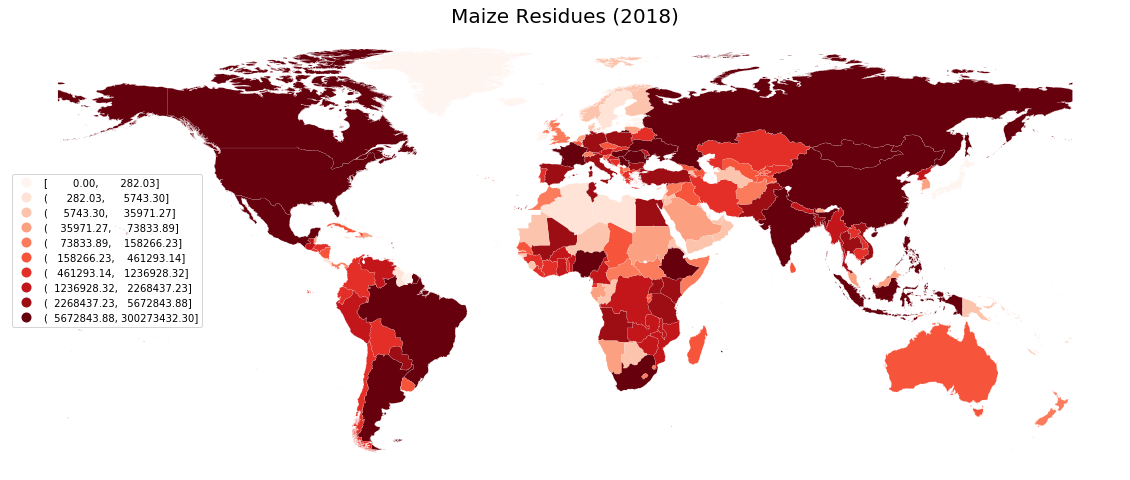

In [21]:
#visualize
fig, ax = plt.subplots(figsize=(20, 15))
#barley17_g.plot(column='barley_value', missing_kwds={'color': 'lightgrey'})
maize18_g.plot(column='Maize_Residue',scheme='quantiles',k=10, 
         cmap=plt.cm.Reds, alpha=1, legend=True,legend_kwds=dict(loc='center left'),
         edgecolor='w', linewidth=0.1,ax=ax,
               
       )
ax.set_axis_off()
ax.set_title("Maize Residues (2018)", fontsize=20)

In [22]:
maize18_g["Area Code (FAO)"]=maize18_g["Country Code"]
maize18_g

Country Code                                            Country  \
0             2.0                                        Afghanistan   
1             3.0                                            Albania   
2             4.0                                            Algeria   
3             5.0                                     American Samoa   
4             6.0                                            Andorra   
5             7.0                                             Angola   
6           258.0                                           Anguilla   
7             8.0                                Antigua and Barbuda   
8             9.0                                          Argentina   
9             1.0                                            Armenia   
10           22.0                                              Aruba   
11           10.0                                          Australia   
12           11.0                                            Austria   
13           52.0                                         Azerbaijan   
14           12.0                                            Bahamas   
15           13.0                                            Bahrain   
16           16.0                                         Bangladesh   
17           14.0                                           Barbados   
18           57.0                                            Belarus   
19          255.0                                            Belgium   
20           23.0                                             Belize   
21           53.0                                              Benin   
22           17.0                                            Bermuda   
23           18.0                                             Bhutan   
24           19.0                   Bolivia (Plurinational State of)   
25           80.0                             Bosnia and Herzegovina   
26           20.0                                           Botswana   
27           21.0                                             Brazil   
28          239.0                             British Virgin Islands   
29           26.0                                  Brunei Darussalam   
30           27.0                                           Bulgaria   
31          233.0                                       Burkina Faso   
32           29.0                                            Burundi   
33           35.0                                         Cabo Verde   
34          115.0                                           Cambodia   
35           32.0                                           Cameroon   
36           33.0                                             Canada   
37           36.0                                     Cayman Islands   
38           37.0                           Central African Republic   
39           39.0                                               Chad   
40           40.0                                              Chile   
41          351.0                                              China   
42           96.0                               China, Hong Kong SAR   
43          128.0                                   China, Macao SAR   
44           44.0                                           Colombia   
45           45.0                                            Comoros   
46           46.0                                              Congo   
47           47.0                                       Cook Islands   
48           48.0                                         Costa Rica   
49          107.0                                      Côte d'Ivoire   
50           98.0                                            Croatia   
51           49.0                                               Cuba   
52           50.0                                             Cyprus   
53          167.0                                            Czechia   
54          116.0              Democratic Peo

In [23]:
#do spatial analysis
#global spatial analysis
maize18_gs=maize18_g
maize_binary=[]
for i in range(0,maize18_gs.shape[0]):
    maize_binary.append(maize18_gs.loc[i,'Maize_Residue']> maize18_gs['Maize_Residue'].median())

In [24]:
maize18_gs

Country Code                                            Country  \
0             2.0                                        Afghanistan   
1             3.0                                            Albania   
2             4.0                                            Algeria   
3             5.0                                     American Samoa   
4             6.0                                            Andorra   
5             7.0                                             Angola   
6           258.0                                           Anguilla   
7             8.0                                Antigua and Barbuda   
8             9.0                                          Argentina   
9             1.0                                            Armenia   
10           22.0                                              Aruba   
11           10.0                                          Australia   
12           11.0                                            Austria   
13           52.0                                         Azerbaijan   
14           12.0                                            Bahamas   
15           13.0                                            Bahrain   
16           16.0                                         Bangladesh   
17           14.0                                           Barbados   
18           57.0                                            Belarus   
19          255.0                                            Belgium   
20           23.0                                             Belize   
21           53.0                                              Benin   
22           17.0                                            Bermuda   
23           18.0                                             Bhutan   
24           19.0                   Bolivia (Plurinational State of)   
25           80.0                             Bosnia and Herzegovina   
26           20.0                                           Botswana   
27           21.0                                             Brazil   
28          239.0                             British Virgin Islands   
29           26.0                                  Brunei Darussalam   
30           27.0                                           Bulgaria   
31          233.0                                       Burkina Faso   
32           29.0                                            Burundi   
33           35.0                                         Cabo Verde   
34          115.0                                           Cambodia   
35           32.0                                           Cameroon   
36           33.0                                             Canada   
37           36.0                                     Cayman Islands   
38           37.0                           Central African Republic   
39           39.0                                               Chad   
40           40.0                                              Chile   
41          351.0                                              China   
42           96.0                               China, Hong Kong SAR   
43          128.0                                   China, Macao SAR   
44           44.0                                           Colombia   
45           45.0                                            Comoros   
46           46.0                                              Congo   
47           47.0                                       Cook Islands   
48           48.0                                         Costa Rica   
49          107.0                                      Côte d'Ivoire   
50           98.0                                            Croatia   
51           49.0                                               Cuba   
52           50.0                                             Cyprus   
53          167.0                                            Czechia   
54          116.0              Democratic Peo

In [25]:
labels = ['Low value', 'High value']
maize_binary= [labels[i] for i in 1*maize_binary] 
maize18_gs['maize_binary'] = maize_binary

Text(0.5, 1, 'High and Low Values of Maize Residues (2018)')

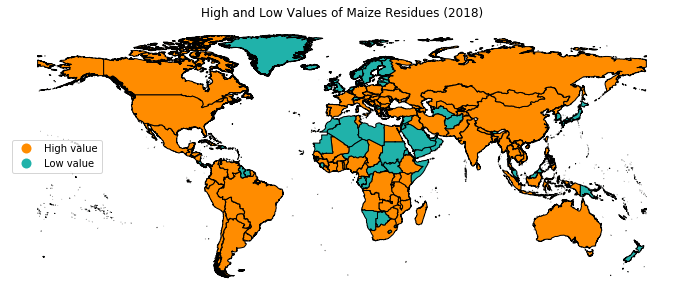

In [26]:
#visualize high and low values
from matplotlib import colors
fig = plt.figure(figsize=(12,10))
ax = plt.gca()
cmap = colors.ListedColormap(['darkorange', 'lightseagreen'])  
maize18_gs.plot(column='maize_binary', cmap=cmap ,edgecolor='black', legend=True,legend_kwds=dict(loc='center left'), ax=ax)
ax.set_axis_off()
ax.set_title("High and Low Values of Maize Residues (2018)")

In [27]:
#global autocorrelation
from pysal.explore import esda 
maize_18gx_binary = 1 * (maize18_gs['Maize_Residue']>maize18_gs['Maize_Residue'].median()) # convert back to binary
maize_W_queen = lps.weights.Queen.from_dataframe(maize18_gs)
maize_W_queen.transform = 'b'
#np.random.seed(12345) 
maize_jc = esda.join_counts.Join_Counts(maize_18gx_binary,maize_W_queen)

('WARNING: ', 3, ' is an island (no neighbors)')
('WARNING: ', 6, ' is an island (no neighbors)')
('WARNING: ', 7, ' is an island (no neighbors)')
('WARNING: ', 10, ' is an island (no neighbors)')
('WARNING: ', 11, ' is an island (no neighbors)')
('WARNING: ', 14, ' is an island (no neighbors)')
('WARNING: ', 15, ' is an island (no neighbors)')
('WARNING: ', 17, ' is an island (no neighbors)')
('WARNING: ', 22, ' is an island (no neighbors)')
('WARNING: ', 28, ' is an island (no neighbors)')
('WARNING: ', 33, ' is an island (no neighbors)')
('WARNING: ', 37, ' is an island (no neighbors)')
('WARNING: ', 43, ' is an island (no neighbors)')
('WARNING: ', 45, ' is an island (no neighbors)')
('WARNING: ', 47, ' is an island (no neighbors)')
('WARNING: ', 51, ' is an island (no neighbors)')
('WARNING: ', 52, ' is an island (no neighbors)')
('WARNING: ', 58, ' is an island (no neighbors)')
('WARNING: ', 68, ' is an island (no neighbors)')
('WARNING: ', 69, ' is an island (no neighbors)')
('W

Text(0.5, 0, "Moran's I")

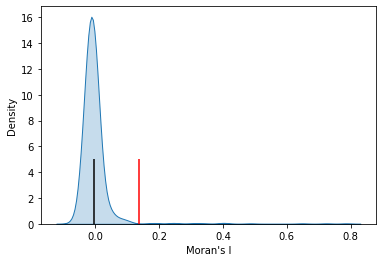

In [28]:
maize_mi = esda.moran.Moran(maize18_gs['Maize_Residue'], maize_W_queen)
sns.kdeplot(maize_mi.sim, shade=True)
plt.vlines(maize_mi.I, 0, 5, color='r')
plt.vlines(maize_mi.EI, 0, 5)
plt.xlabel("Moran's I")

In [29]:
# Check the statistical significance
maize_mi.p_sim

0.017

In [30]:
maize_w_queen = Queen.from_dataframe(maize18_gs)

In [31]:
I_price = ps.explore.esda.Moran(maize18_gs['Maize_Residue'].values, maize_w_queen)  # Moran's I
I_price.I, I_price.p_sim 

('WARNING: ', 3, ' is an island (no neighbors)')
('WARNING: ', 6, ' is an island (no neighbors)')
('WARNING: ', 7, ' is an island (no neighbors)')
('WARNING: ', 10, ' is an island (no neighbors)')
('WARNING: ', 11, ' is an island (no neighbors)')
('WARNING: ', 14, ' is an island (no neighbors)')
('WARNING: ', 15, ' is an island (no neighbors)')
('WARNING: ', 17, ' is an island (no neighbors)')
('WARNING: ', 22, ' is an island (no neighbors)')
('WARNING: ', 28, ' is an island (no neighbors)')
('WARNING: ', 33, ' is an island (no neighbors)')
('WARNING: ', 37, ' is an island (no neighbors)')
('WARNING: ', 43, ' is an island (no neighbors)')
('WARNING: ', 45, ' is an island (no neighbors)')
('WARNING: ', 47, ' is an island (no neighbors)')
('WARNING: ', 51, ' is an island (no neighbors)')
('WARNING: ', 52, ' is an island (no neighbors)')
('WARNING: ', 58, ' is an island (no neighbors)')
('WARNING: ', 68, ' is an island (no neighbors)')
('WARNING: ', 69, ' is an island (no neighbors)')
('W

(0.13725495996451892, 0.018)

In [32]:
#local spatial autocorrelation
maize_lisa = ps.explore.esda.Moran_Local(maize18_gs['Maize_Residue'].values,maize_W_queen, permutations=999)

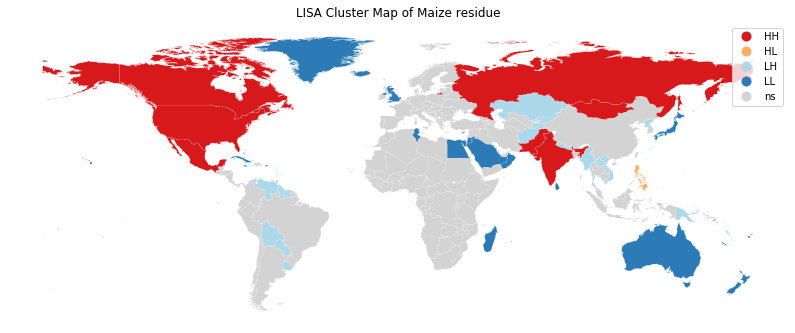

In [33]:
from pysal.viz.splot.esda import lisa_cluster
fig, ax=plt.subplots(1, figsize=(14,10))
fig = lisa_cluster(maize_lisa,maize18_gs, ax=ax)
plt.title("LISA Cluster Map of Maize residue")
plt.show() 

In [34]:
#do prediction
#read fertilizer csv 
fertilizers_18=pd.read_csv("dataset/fertilizer/synthetic_fertilizers_per_area_2018.csv",usecols=["Area Code (FAO)","Ferti_Value"])

In [35]:
#merge fertilizer data
maize18_g1=pd.merge(maize18_g,fertilizers_18,on="Area Code (FAO)",how="outer")
maize18_g1["Area Code (FAO)"]=maize18_g1["Country Code"]

In [36]:
#fill fertilizer missing values 
def ckdnearest(gdA,missing):    
    nA = np.array(list(gdA.centroid.apply(lambda x: (x.x, x.y))))
    btree = cKDTree(nA)
    for i in missing:
        nB=np.array(list([gdA.loc[i,"centroid"].x,gdA.loc[i,"centroid"].y]))
        dist, idx = btree.query(nB, k=4)
        sum_r=0
        k=0
        for j in idx:
            if not np.isnan(gdA.loc[j,"Ferti_Value"]):
                k=k+1
                sum_r=sum_r+gdA.loc[j,"Ferti_Value"]
        if k!=0:
            a_sum=sum_r/k
            gdA.loc[i,"Ferti_Value"]=a_sum
while len(maize18_g1[np.isnan(maize18_g1["Ferti_Value"].values)].index)!=0:
    ckdnearest(maize18_g1,maize18_g1[np.isnan(maize18_g1["Ferti_Value"].values)].index)

In [37]:
maize18_g1

Country Code                                            Country  \
0             2.0                                        Afghanistan   
1             3.0                                            Albania   
2             4.0                                            Algeria   
3             5.0                                     American Samoa   
4             6.0                                            Andorra   
5             7.0                                             Angola   
6           258.0                                           Anguilla   
7             8.0                                Antigua and Barbuda   
8             9.0                                          Argentina   
9             1.0                                            Armenia   
10           22.0                                              Aruba   
11           10.0                                          Australia   
12           11.0                                            Austria   
13           52.0                                         Azerbaijan   
14           12.0                                            Bahamas   
15           13.0                                            Bahrain   
16           16.0                                         Bangladesh   
17           14.0                                           Barbados   
18           57.0                                            Belarus   
19          255.0                                            Belgium   
20           23.0                                             Belize   
21           53.0                                              Benin   
22           17.0                                            Bermuda   
23           18.0                                             Bhutan   
24           19.0                   Bolivia (Plurinational State of)   
25           80.0                             Bosnia and Herzegovina   
26           20.0                                           Botswana   
27           21.0                                             Brazil   
28          239.0                             British Virgin Islands   
29           26.0                                  Brunei Darussalam   
30           27.0                                           Bulgaria   
31          233.0                                       Burkina Faso   
32           29.0                                            Burundi   
33           35.0                                         Cabo Verde   
34          115.0                                           Cambodia   
35           32.0                                           Cameroon   
36           33.0                                             Canada   
37           36.0                                     Cayman Islands   
38           37.0                           Central African Republic   
39           39.0                                               Chad   
40           40.0                                              Chile   
41          351.0                                              China   
42           96.0                               China, Hong Kong SAR   
43          128.0                                   China, Macao SAR   
44           44.0                                           Colombia   
45           45.0                                            Comoros   
46           46.0                                              Congo   
47           47.0                                       Cook Islands   
48           48.0                                         Costa Rica   
49          107.0                                      Côte d'Ivoire   
50           98.0                                            Croatia   
51           49.0                                               Cuba   
52           50.0                                             Cyprus   
53          167.0                                            Czechia   
54          116.0              Democratic Peo

In [38]:
#read csv 
cropland_18=pd.read_csv("dataset/cropland/crop_land_2018.csv",usecols=["Area Code (FAO)","Land_Value"])
cropland_18.head()

Area Code (FAO)  Land_Value
0                3   3050.6290
1                7   5471.1183
2                9  27913.0415
3               10  52921.9173
4               11   2626.2094

In [39]:
maize18_g2=pd.merge(maize18_g1,cropland_18,on="Area Code (FAO)",how="outer")

In [40]:
#fill crop land missing values 
def ckdnearest(gdA,missing):    
    nA = np.array(list(gdA.centroid.apply(lambda x: (x.x, x.y))))
    btree = cKDTree(nA)
    for i in missing:
        nB=np.array(list([gdA.loc[i,"centroid"].x,gdA.loc[i,"centroid"].y]))
        dist, idx = btree.query(nB, k=5)
        land_sum=0
        area_sum=0
        k=0
        for j in idx:
            if not np.isnan(gdA.loc[j,"Land_Value"]):
                land_sum=land_sum+gdA.loc[j,"Land_Value"]
                area_sum=area_sum+gdA.loc[j,"country_area"]
                k=k+1
        if k!=0:
            gdA.loc[i,"Land_Value"]=(land_sum/area_sum)*gdA.loc[i,"country_area"]
while len(maize18_g2[np.isnan(maize18_g2["Land_Value"].values)].index)!=0:
    ckdnearest(maize18_g2,maize18_g2[np.isnan(maize18_g2["Land_Value"].values)].index)

In [41]:
maize18_g2

Country Code                                            Country  \
0             2.0                                        Afghanistan   
1             3.0                                            Albania   
2             4.0                                            Algeria   
3             5.0                                     American Samoa   
4             6.0                                            Andorra   
5             7.0                                             Angola   
6           258.0                                           Anguilla   
7             8.0                                Antigua and Barbuda   
8             9.0                                          Argentina   
9             1.0                                            Armenia   
10           22.0                                              Aruba   
11           10.0                                          Australia   
12           11.0                                            Austria   
13           52.0                                         Azerbaijan   
14           12.0                                            Bahamas   
15           13.0                                            Bahrain   
16           16.0                                         Bangladesh   
17           14.0                                           Barbados   
18           57.0                                            Belarus   
19          255.0                                            Belgium   
20           23.0                                             Belize   
21           53.0                                              Benin   
22           17.0                                            Bermuda   
23           18.0                                             Bhutan   
24           19.0                   Bolivia (Plurinational State of)   
25           80.0                             Bosnia and Herzegovina   
26           20.0                                           Botswana   
27           21.0                                             Brazil   
28          239.0                             British Virgin Islands   
29           26.0                                  Brunei Darussalam   
30           27.0                                           Bulgaria   
31          233.0                                       Burkina Faso   
32           29.0                                            Burundi   
33           35.0                                         Cabo Verde   
34          115.0                                           Cambodia   
35           32.0                                           Cameroon   
36           33.0                                             Canada   
37           36.0                                     Cayman Islands   
38           37.0                           Central African Republic   
39           39.0                                               Chad   
40           40.0                                              Chile   
41          351.0                                              China   
42           96.0                               China, Hong Kong SAR   
43          128.0                                   China, Macao SAR   
44           44.0                                           Colombia   
45           45.0                                            Comoros   
46           46.0                                              Congo   
47           47.0                                       Cook Islands   
48           48.0                                         Costa Rica   
49          107.0                                      Côte d'Ivoire   
50           98.0                                            Croatia   
51           49.0                                               Cuba   
52           50.0                                             Cyprus   
53          167.0                                            Czechia   
54          116.0              Democratic Peo

In [42]:
#read climate data
temperature_18=pd.read_csv("dataset/climate/climate18.csv",usecols=["temperature_mean_Maize","temperature_max","temperature_min","Country Code"])
temperature_18.head()

temperature_max  temperature_min  Country Code  temperature_mean_Maize
0            30.82            15.20         101.0                  26.880
1            28.62            21.06         131.0                  26.190
2            28.51           -11.78          40.0                   6.575
3            32.75           -12.02          19.0                  25.360
4            37.17             0.07         170.0                  24.855

In [43]:
maize18_g3=pd.merge(maize18_g2,temperature_18,on="Country Code",how="outer")
maize18_g3=maize18_g3.drop([227,228,229,230])
maize18_g3

Country Code                                            Country  \
0             2.0                                        Afghanistan   
1             3.0                                            Albania   
2             4.0                                            Algeria   
3             5.0                                     American Samoa   
4             6.0                                            Andorra   
5             7.0                                             Angola   
6           258.0                                           Anguilla   
7             8.0                                Antigua and Barbuda   
8             9.0                                          Argentina   
9             1.0                                            Armenia   
10           22.0                                              Aruba   
11           10.0                                          Australia   
12           11.0                                            Austria   
13           52.0                                         Azerbaijan   
14           12.0                                            Bahamas   
15           13.0                                            Bahrain   
16           16.0                                         Bangladesh   
17           14.0                                           Barbados   
18           57.0                                            Belarus   
19          255.0                                            Belgium   
20           23.0                                             Belize   
21           53.0                                              Benin   
22           17.0                                            Bermuda   
23           18.0                                             Bhutan   
24           19.0                   Bolivia (Plurinational State of)   
25           80.0                             Bosnia and Herzegovina   
26           20.0                                           Botswana   
27           21.0                                             Brazil   
28          239.0                             British Virgin Islands   
29           26.0                                  Brunei Darussalam   
30           27.0                                           Bulgaria   
31          233.0                                       Burkina Faso   
32           29.0                                            Burundi   
33           35.0                                         Cabo Verde   
34          115.0                                           Cambodia   
35           32.0                                           Cameroon   
36           33.0                                             Canada   
37           36.0                                     Cayman Islands   
38           37.0                           Central African Republic   
39           39.0                                               Chad   
40           40.0                                              Chile   
41          351.0                                              China   
42           96.0                               China, Hong Kong SAR   
43          128.0                                   China, Macao SAR   
44           44.0                                           Colombia   
45           45.0                                            Comoros   
46           46.0                                              Congo   
47           47.0                                       Cook Islands   
48           48.0                                         Costa Rica   
49          107.0                                      Côte d'Ivoire   
50           98.0                                            Croatia   
51           49.0                                               Cuba   
52           50.0                                             Cyprus   
53          167.0                                            Czechia   
54          116.0              Democratic Peo

In [44]:
#fill temperature missing values median
def ckdnearest(gdA,missing):    
    nA = np.array(list(gdA.centroid.apply(lambda x: (x.x, x.y))))
    btree = cKDTree(nA)
    for i in missing:
        nB=np.array(list([gdA.loc[i,"centroid"].x,gdA.loc[i,"centroid"].y]))
        dist, idx = btree.query(nB, k=4)
        t_sum=0
        k=0
        for j in idx:
            if not np.isnan(gdA.loc[j,"temperature_mean_Maize"]):
                k=k+1
                t_sum=t_sum+gdA.loc[j,"temperature_mean_Maize"]
        if k!=0:
            a_sum=t_sum/k
            gdA.loc[i,"temperature_mean_Maize"]=a_sum
            
while len(maize18_g3[np.isnan(maize18_g3["temperature_mean_Maize"].values)].index)!=0:
    ckdnearest(maize18_g3,maize18_g3[np.isnan(maize18_g3["temperature_mean_Maize"].values)].index)

In [45]:
#fill temperature missing values max
def ckdnearest(gdA,missing):    
    nA = np.array(list(gdA.centroid.apply(lambda x: (x.x, x.y))))
    btree = cKDTree(nA)
    for i in missing:
        nB=np.array(list([gdA.loc[i,"centroid"].x,gdA.loc[i,"centroid"].y]))
        dist, idx = btree.query(nB, k=4)
        t_sum=0
        k=0
        for j in idx:
            if not np.isnan(gdA.loc[j,"temperature_max"]):
                k=k+1
                t_sum=t_sum+gdA.loc[j,"temperature_max"]
        if k!=0:
            a_sum=t_sum/k
            gdA.loc[i,"temperature_max"]=a_sum
            
while len(maize18_g3[np.isnan(maize18_g3["temperature_max"].values)].index)!=0:
    ckdnearest(maize18_g3,maize18_g3[np.isnan(maize18_g3["temperature_max"].values)].index)

In [46]:
#fill temperature missing values min
def ckdnearest(gdA,missing):    
    nA = np.array(list(gdA.centroid.apply(lambda x: (x.x, x.y))))
    btree = cKDTree(nA)
    for i in missing:
        nB=np.array(list([gdA.loc[i,"centroid"].x,gdA.loc[i,"centroid"].y]))
        dist, idx = btree.query(nB, k=4)
        t_sum=0
        k=0
        for j in idx:
            if not np.isnan(gdA.loc[j,"temperature_min"]):
                k=k+1
                t_sum=t_sum+gdA.loc[j,"temperature_min"]
        if k!=0:
            a_sum=t_sum/k
            gdA.loc[i,"temperature_min"]=a_sum
            
while len(maize18_g3[np.isnan(maize18_g3["temperature_min"].values)].index)!=0:
    ckdnearest(maize18_g3,maize18_g3[np.isnan(maize18_g3["temperature_min"].values)].index)

In [47]:
maize18_g3

Country Code                                            Country  \
0             2.0                                        Afghanistan   
1             3.0                                            Albania   
2             4.0                                            Algeria   
3             5.0                                     American Samoa   
4             6.0                                            Andorra   
5             7.0                                             Angola   
6           258.0                                           Anguilla   
7             8.0                                Antigua and Barbuda   
8             9.0                                          Argentina   
9             1.0                                            Armenia   
10           22.0                                              Aruba   
11           10.0                                          Australia   
12           11.0                                            Austria   
13           52.0                                         Azerbaijan   
14           12.0                                            Bahamas   
15           13.0                                            Bahrain   
16           16.0                                         Bangladesh   
17           14.0                                           Barbados   
18           57.0                                            Belarus   
19          255.0                                            Belgium   
20           23.0                                             Belize   
21           53.0                                              Benin   
22           17.0                                            Bermuda   
23           18.0                                             Bhutan   
24           19.0                   Bolivia (Plurinational State of)   
25           80.0                             Bosnia and Herzegovina   
26           20.0                                           Botswana   
27           21.0                                             Brazil   
28          239.0                             British Virgin Islands   
29           26.0                                  Brunei Darussalam   
30           27.0                                           Bulgaria   
31          233.0                                       Burkina Faso   
32           29.0                                            Burundi   
33           35.0                                         Cabo Verde   
34          115.0                                           Cambodia   
35           32.0                                           Cameroon   
36           33.0                                             Canada   
37           36.0                                     Cayman Islands   
38           37.0                           Central African Republic   
39           39.0                                               Chad   
40           40.0                                              Chile   
41          351.0                                              China   
42           96.0                               China, Hong Kong SAR   
43          128.0                                   China, Macao SAR   
44           44.0                                           Colombia   
45           45.0                                            Comoros   
46           46.0                                              Congo   
47           47.0                                       Cook Islands   
48           48.0                                         Costa Rica   
49          107.0                                      Côte d'Ivoire   
50           98.0                                            Croatia   
51           49.0                                               Cuba   
52           50.0                                             Cyprus   
53          167.0                                            Czechia   
54          116.0              Democratic Peo

In [48]:
#read rainfall data
rainfall_18=pd.read_csv("dataset/climate/rainfall_18.csv",usecols=["Maize_rainfall_mean","rainfall_max","rainfall_min","Country Code"])
rainfall_18.head()

rainfall_max  rainfall_min  Country Code  Maize_rainfall_mean
0        5763.3        1070.8         101.0               2730.9
1        4889.3        2002.7         131.0               3022.9
2        3518.3          18.8          40.0                523.7
3        4620.9         107.8          19.0               1175.9
4        5273.9           6.0         170.0               1556.3

In [49]:
maize18_g4=pd.merge(maize18_g3,rainfall_18,on="Country Code",how="outer")
maize18_g4=maize18_g4.drop([227,228,229,230])
maize18_g4

Country Code                                            Country  \
0             2.0                                        Afghanistan   
1             3.0                                            Albania   
2             4.0                                            Algeria   
3             5.0                                     American Samoa   
4             6.0                                            Andorra   
5             7.0                                             Angola   
6           258.0                                           Anguilla   
7             8.0                                Antigua and Barbuda   
8             9.0                                          Argentina   
9             1.0                                            Armenia   
10           22.0                                              Aruba   
11           10.0                                          Australia   
12           11.0                                            Austria   
13           52.0                                         Azerbaijan   
14           12.0                                            Bahamas   
15           13.0                                            Bahrain   
16           16.0                                         Bangladesh   
17           14.0                                           Barbados   
18           57.0                                            Belarus   
19          255.0                                            Belgium   
20           23.0                                             Belize   
21           53.0                                              Benin   
22           17.0                                            Bermuda   
23           18.0                                             Bhutan   
24           19.0                   Bolivia (Plurinational State of)   
25           80.0                             Bosnia and Herzegovina   
26           20.0                                           Botswana   
27           21.0                                             Brazil   
28          239.0                             British Virgin Islands   
29           26.0                                  Brunei Darussalam   
30           27.0                                           Bulgaria   
31          233.0                                       Burkina Faso   
32           29.0                                            Burundi   
33           35.0                                         Cabo Verde   
34          115.0                                           Cambodia   
35           32.0                                           Cameroon   
36           33.0                                             Canada   
37           36.0                                     Cayman Islands   
38           37.0                           Central African Republic   
39           39.0                                               Chad   
40           40.0                                              Chile   
41          351.0                                              China   
42           96.0                               China, Hong Kong SAR   
43          128.0                                   China, Macao SAR   
44           44.0                                           Colombia   
45           45.0                                            Comoros   
46           46.0                                              Congo   
47           47.0                                       Cook Islands   
48           48.0                                         Costa Rica   
49          107.0                                      Côte d'Ivoire   
50           98.0                                            Croatia   
51           49.0                                               Cuba   
52           50.0                                             Cyprus   
53          167.0                                            Czechia   
54          116.0              Democratic Peo

In [50]:
#fill rainfall missing values 
def ckdnearest(gdA,missing):    
    nA = np.array(list(gdA.centroid.apply(lambda x: (x.x, x.y))))
    btree = cKDTree(nA)
    for i in missing:
        nB=np.array(list([gdA.loc[i,"centroid"].x,gdA.loc[i,"centroid"].y]))
        dist, idx = btree.query(nB, k=4)
        t_sum=0
        k=0
        for j in idx:
            if not np.isnan(gdA.loc[j,"Maize_rainfall_mean"]):
                k=k+1
                t_sum=t_sum+gdA.loc[j,"Maize_rainfall_mean"]
        if k!=0:
            a_sum=t_sum/k
            gdA.loc[i,"Maize_rainfall_mean"]=a_sum
            
while len(maize18_g4[np.isnan(maize18_g4["Maize_rainfall_mean"].values)].index)!=0:
    ckdnearest(maize18_g4,maize18_g4[np.isnan(maize18_g4["Maize_rainfall_mean"].values)].index)

In [51]:
#fill rainfall missing values  max
def ckdnearest(gdA,missing):    
    nA = np.array(list(gdA.centroid.apply(lambda x: (x.x, x.y))))
    btree = cKDTree(nA)
    for i in missing:
        nB=np.array(list([gdA.loc[i,"centroid"].x,gdA.loc[i,"centroid"].y]))
        dist, idx = btree.query(nB, k=4)
        t_sum=0
        k=0
        for j in idx:
            if not np.isnan(gdA.loc[j,"rainfall_max"]):
                k=k+1
                t_sum=t_sum+gdA.loc[j,"rainfall_max"]
        if k!=0:
            a_sum=t_sum/k
            gdA.loc[i,"rainfall_max"]=a_sum
            
while len(maize18_g4[np.isnan(maize18_g4["rainfall_max"].values)].index)!=0:
    ckdnearest(maize18_g4,maize18_g4[np.isnan(maize18_g4["rainfall_max"].values)].index)

In [52]:
#fill rainfall missing values  min
def ckdnearest(gdA,missing):    
    nA = np.array(list(gdA.centroid.apply(lambda x: (x.x, x.y))))
    btree = cKDTree(nA)
    for i in missing:
        nB=np.array(list([gdA.loc[i,"centroid"].x,gdA.loc[i,"centroid"].y]))
        dist, idx = btree.query(nB, k=4)
        t_sum=0
        k=0
        for j in idx:
            if not np.isnan(gdA.loc[j,"rainfall_min"]):
                k=k+1
                t_sum=t_sum+gdA.loc[j,"rainfall_min"]
        if k!=0:
            a_sum=t_sum/k
            gdA.loc[i,"rainfall_min"]=a_sum
            
while len(maize18_g4[np.isnan(maize18_g4["rainfall_min"].values)].index)!=0:
    ckdnearest(maize18_g4,maize18_g4[np.isnan(maize18_g4["rainfall_min"].values)].index)

In [53]:
maize18_g4

Country Code                                            Country  \
0             2.0                                        Afghanistan   
1             3.0                                            Albania   
2             4.0                                            Algeria   
3             5.0                                     American Samoa   
4             6.0                                            Andorra   
5             7.0                                             Angola   
6           258.0                                           Anguilla   
7             8.0                                Antigua and Barbuda   
8             9.0                                          Argentina   
9             1.0                                            Armenia   
10           22.0                                              Aruba   
11           10.0                                          Australia   
12           11.0                                            Austria   
13           52.0                                         Azerbaijan   
14           12.0                                            Bahamas   
15           13.0                                            Bahrain   
16           16.0                                         Bangladesh   
17           14.0                                           Barbados   
18           57.0                                            Belarus   
19          255.0                                            Belgium   
20           23.0                                             Belize   
21           53.0                                              Benin   
22           17.0                                            Bermuda   
23           18.0                                             Bhutan   
24           19.0                   Bolivia (Plurinational State of)   
25           80.0                             Bosnia and Herzegovina   
26           20.0                                           Botswana   
27           21.0                                             Brazil   
28          239.0                             British Virgin Islands   
29           26.0                                  Brunei Darussalam   
30           27.0                                           Bulgaria   
31          233.0                                       Burkina Faso   
32           29.0                                            Burundi   
33           35.0                                         Cabo Verde   
34          115.0                                           Cambodia   
35           32.0                                           Cameroon   
36           33.0                                             Canada   
37           36.0                                     Cayman Islands   
38           37.0                           Central African Republic   
39           39.0                                               Chad   
40           40.0                                              Chile   
41          351.0                                              China   
42           96.0                               China, Hong Kong SAR   
43          128.0                                   China, Macao SAR   
44           44.0                                           Colombia   
45           45.0                                            Comoros   
46           46.0                                              Congo   
47           47.0                                       Cook Islands   
48           48.0                                         Costa Rica   
49          107.0                                      Côte d'Ivoire   
50           98.0                                            Croatia   
51           49.0                                               Cuba   
52           50.0                                             Cyprus   
53          167.0                                            Czechia   
54          116.0              Democratic Peo

In [54]:
maize18_g4.to_csv("dataset/crop_residue_and _indicators/maize_residue_indicators.csv",columns=["Country Code","Country","CONTINENT","Maize_Residue","country_area","Ferti_Value","Land_Value",
                                                                 "temperature_max","temperature_min","temperature_mean_Maize",
                                                                "rainfall_max","rainfall_min", "Maize_rainfall_mean"])

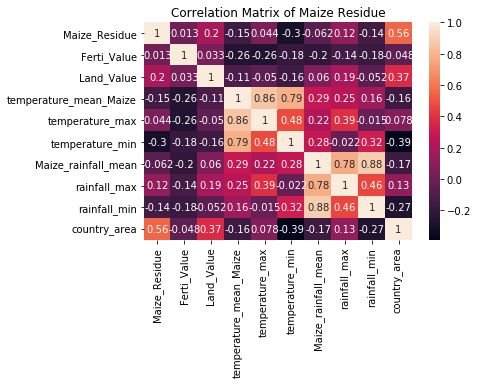

In [55]:
#do prediction
#do coefficient matrix
maize_df= pd.DataFrame(maize18_g4,columns=['Maize_Residue','Ferti_Value',"Land_Value","temperature_mean_Maize",
                                             "temperature_max","temperature_min","Maize_rainfall_mean","rainfall_max","rainfall_min","country_area"])
corrMatrix = maize_df.corr()
sns.heatmap(corrMatrix, annot=True)
plt.title("Correlation Matrix of Maize Residue")
plt.show()

In [56]:
#X=maize_df[["Land_Value","temperature_mean_Maize","temperature_max","temperature_min","Maize_rainfall_mean","rainfall_max","rainfall_min","country_area"]]
X=maize_df[["temperature_mean_Maize","temperature_max","Maize_rainfall_mean","rainfall_max","rainfall_min","country_area"]]
y=maize_df[['Maize_Residue']]

In [57]:
import statsmodels.api as sm
y= np.array(y) # define output/dependant variable
lm = sm.OLS(y, X).fit()
#evaluation
lm_pre_y = lm.predict(X)
print("Ordinary Least Square model:")
#RMSE
print("root mean squared error:", sqrt(metrics.mean_squared_error(y,lm_pre_y)))

Ordinary Least Square model:
root mean squared error: 20789868.984286316


In [58]:
lm.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                      y   R-squared (uncentered):                   0.351
Model:                            OLS   Adj. R-squared (uncentered):              0.334
Method:                 Least Squares   F-statistic:                              19.94
Date:                Fri, 03 Sep 2021   Prob (F-statistic):                    1.39e-18
Time:                        02:30:38   Log-Likelihood:                         -4147.0
No. Observations:                 227   AIC:                                      8306.
Df Residuals:                     221   BIC:                                      8327.
Df Model:                           6                                                  
Covariance Type:            nonrobust                                                  
==========================================================================================
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
temperature_mean_Maize -8.781e+05   3.93e+05     -2.234      0.026   -1.65e+06   -1.03e+05
temperature_max         6.793e+05   3.62e+05      1.875      0.062   -3.49e+04    1.39e+06
Maize_rainfall_mean     4882.4656   7980.354      0.612      0.541   -1.08e+04    2.06e+04
rainfall_max            -807.0736   2749.351     -0.294      0.769   -6225.374    4611.227
rainfall_min           -3129.8184   6237.236     -0.502      0.616   -1.54e+04    9162.254
country_area               7.0562      0.913      7.729      0.000       5.257       8.855
==============================================================================
Omnibus:                      289.719   Durbin-Watson:                   2.058
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            39891.826
Skew:                           5.120   Prob(JB):                         0.00
Kurtosis:                      67.131   Cond. No.                     7.11e+05
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[3] The condition number is large, 7.11e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

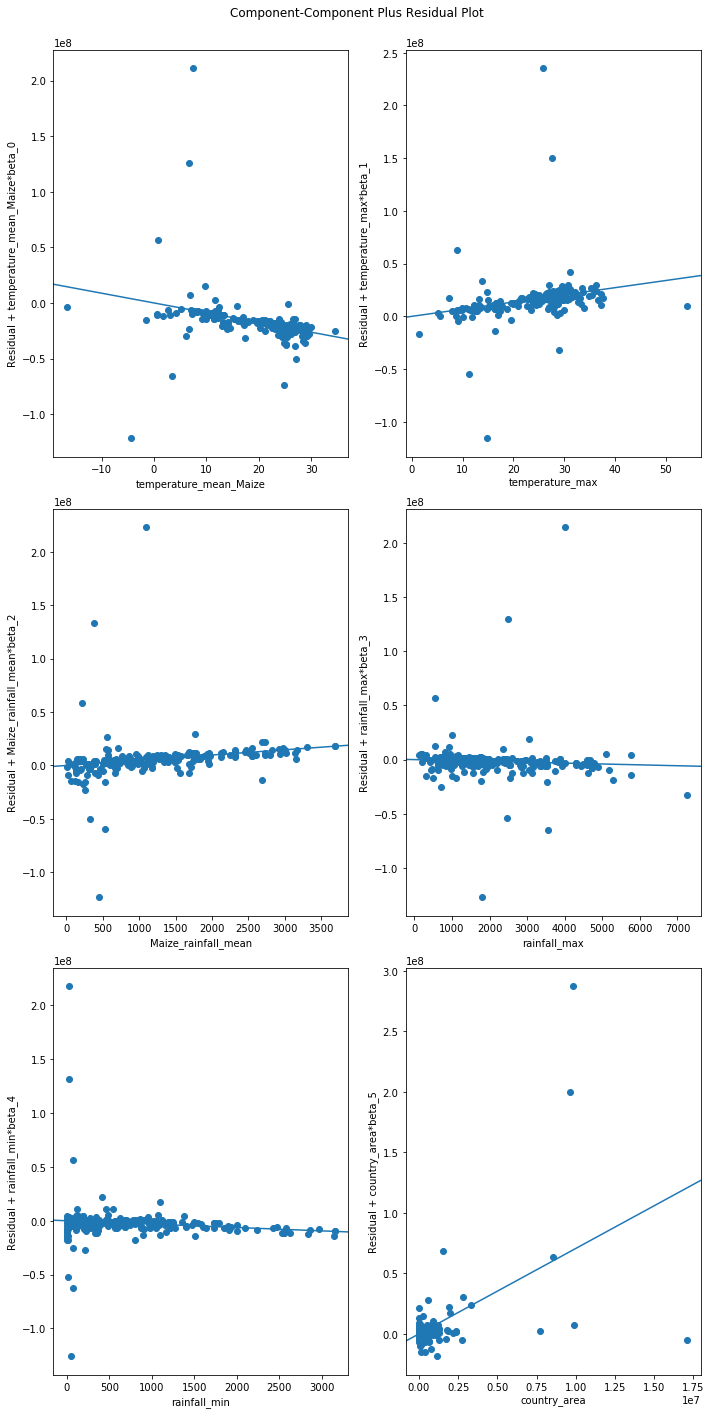

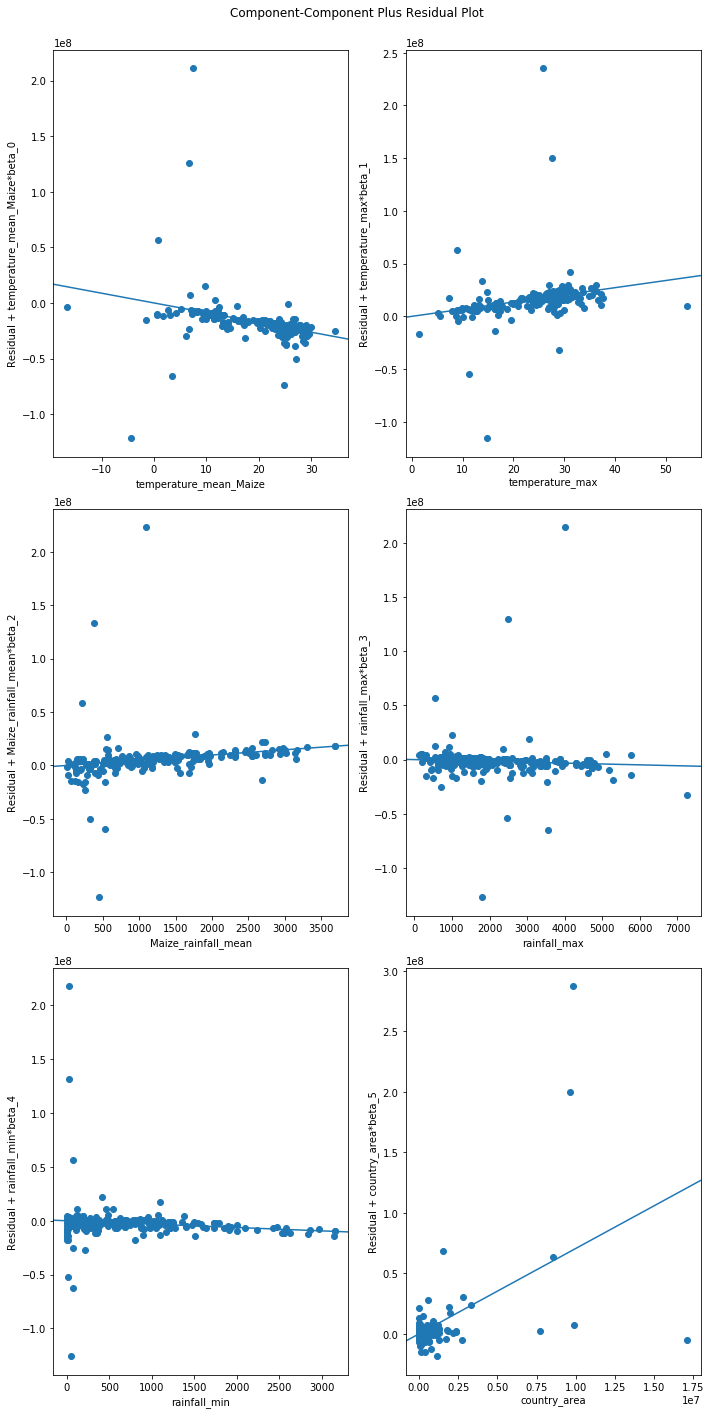

In [59]:
fig=plt.figure(figsize=(10,20))
sm.graphics.plot_ccpr_grid(lm,fig=fig)

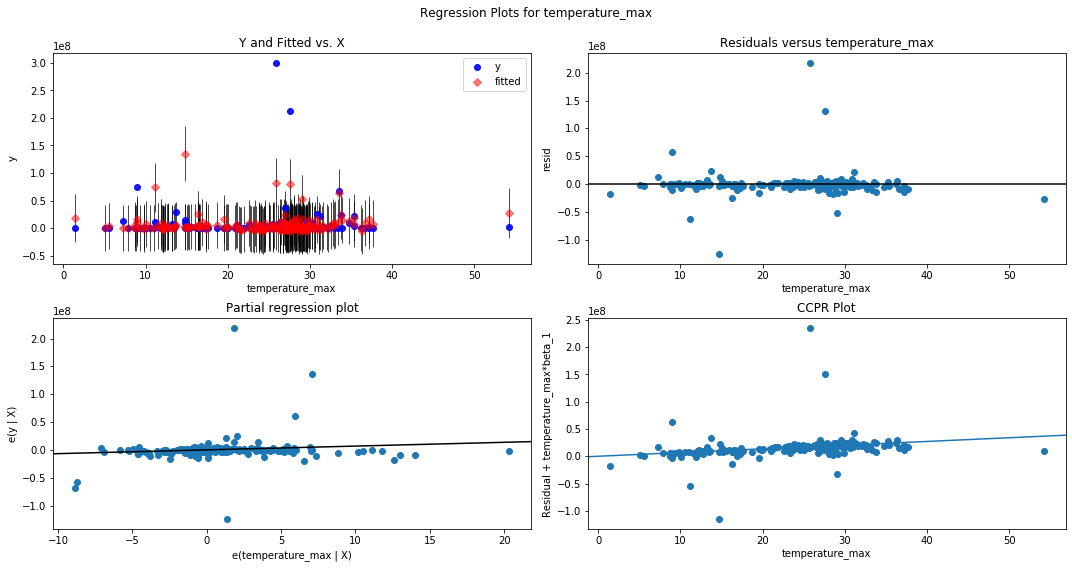

In [60]:
fig = plt.figure(figsize=(15,8))
fig = sm.graphics.plot_regress_exog(lm,"temperature_max", fig =fig)

In [61]:
#lasso regression
import pandas as pd
import numpy as np
from sklearn import model_selection
#from sklearn.linear_model import LassoCV
from sklearn import linear_model
#Lambdas=np.logspace(-5,2,200)
lasso=linear_model.Lasso()
lasso.fit(X,y)
#print(lasso_cv.alpha_)
lasso_pred=lasso.predict(X)
MSE=mean_squared_error(y,lasso_pred)
print("RMSE:",sqrt(MSE))

RMSE: 20780509.515108593


In [62]:
#R-squared
lasso.score(X,y)

0.32886573658972573

In [63]:
#MLP regressor
regr = MLPRegressor(random_state=1, max_iter=500).fit(X, y)
#predict
mlp_pre_y =regr.predict(X)

In [64]:
print("root mean squared error:", sqrt(metrics.mean_squared_error(y,mlp_pre_y)))
## R^2
print("R^2 :",regr.score(X,y))

root mean squared error: 21464223.100721255
R^2 : 0.28397633633362107


In [65]:
#spatial lag and error model

In [66]:
maize_dfg= gpd.GeoDataFrame(maize18_g4,columns=['Maize_Residue',"temperature_mean_Maize","temperature_max","Maize_rainfall_mean","rainfall_max","rainfall_min","country_area","geometry"])
w_queeng = Queen.from_dataframe(maize_dfg)

In [67]:
w_queeng.transform = 'R'

('WARNING: ', 3, ' is an island (no neighbors)')
('WARNING: ', 6, ' is an island (no neighbors)')
('WARNING: ', 7, ' is an island (no neighbors)')
('WARNING: ', 10, ' is an island (no neighbors)')
('WARNING: ', 11, ' is an island (no neighbors)')
('WARNING: ', 14, ' is an island (no neighbors)')
('WARNING: ', 15, ' is an island (no neighbors)')
('WARNING: ', 17, ' is an island (no neighbors)')
('WARNING: ', 22, ' is an island (no neighbors)')
('WARNING: ', 28, ' is an island (no neighbors)')
('WARNING: ', 33, ' is an island (no neighbors)')
('WARNING: ', 37, ' is an island (no neighbors)')
('WARNING: ', 43, ' is an island (no neighbors)')
('WARNING: ', 45, ' is an island (no neighbors)')
('WARNING: ', 47, ' is an island (no neighbors)')
('WARNING: ', 51, ' is an island (no neighbors)')
('WARNING: ', 52, ' is an island (no neighbors)')
('WARNING: ', 58, ' is an island (no neighbors)')
('WARNING: ', 68, ' is an island (no neighbors)')
('WARNING: ', 69, ' is an island (no neighbors)')
('W

In [68]:
#spatial lag model

In [69]:
maize_dfg

Maize_Residue  temperature_mean_Maize  temperature_max  \
0     8.793164e+04               13.870000        26.800000   
1     3.224001e+05               11.925000        17.650000   
2     3.414389e+03               25.150000        29.870000   
3     1.582662e+05               11.525000        16.410000   
4     6.768993e+06               13.430000        25.440000   
5     2.279542e+06               23.705000        27.650000   
6     7.359648e+04               11.660000        12.140000   
7     6.512233e+01               11.660000        12.140000   
8     3.582744e+07               15.820000        26.930000   
9     6.277298e+03                9.910000        14.740000   
10    5.248591e+05               20.968333        22.756667   
11    3.192148e+05               24.700000        29.060000   
12    1.756110e+06                7.180000        12.370000   
13    2.043844e+05               15.295000        19.900000   
14    5.358167e+02               26.305000        26.670000   
15    5.194674e+03               28.871667        29.590000   
16    2.710492e+06               26.020000        27.050000   
17    8.985233e+01               26.410000        26.410000   
18    9.379636e+05                8.260000         9.850000   
19    3.104027e+05               11.360000        12.370000   
20    6.410511e+04               25.925000        27.580000   
21    1.244544e+06               27.950000        29.570000   
22    7.359648e+04               11.660000        12.140000   
23    4.554771e+04                1.640000        16.880000   
24    1.039423e+06               25.360000        32.750000   
25    1.048831e+06               10.680000        15.130000   
26    2.030580e+04               23.350000        25.450000   
27    6.789748e+07               23.700000        33.570000   
28    7.359648e+04               17.050000        17.370000   
29    1.046759e+07               26.415000        29.540000   
30    2.903714e+06               12.850000        16.670000   
31    1.401471e+06               29.035000        30.550000   
32    2.394672e+05               20.645000        22.840000   
33    5.926957e+02               24.270000        24.270000   
34    1.015579e+06               27.680000        28.520000   
35    1.909107e+06               24.475000        29.860000   
36    1.144570e+07                3.470000        11.200000   
37    9.582490e+04               26.531667        27.870000   
38    7.419000e+04               25.230000        28.290000   
39    3.609739e+05               28.440000        30.620000   
40    9.155112e+05                6.575000        28.510000   
41    2.121411e+08                6.580000        27.590000   
42    2.413538e+06               23.820000        23.820000   
43    2.413538e+06               23.958333        26.733333   
44    1.136235e+06               27.000000        54.230000   
45    5.736536e+03               24.210000        24.210000   
46    1.085317e+04               25.320000        27.300000   
47    1.582662e+05               11.525000        16.410000   
48    4.627807e+03               24.390000        26.950000   
49    8.696717e+05               27.851667        29.333333   
50    1.770074e+06               12.365000        15.970000   
51    2.851443e+05               25.490000        27.100000   
52    3.235426e+04               20.590000        21.490000   
53    4.032227e+05                9.830000        12.130000   
54    1.546575e+06                7.690000        11.530000   
55    1.802038e+06               25.200000        28.030000   
56    2.924735e+04                9.770000        10.580000   
57    1.731100e+01               34.520000        36.340000   
58    1.566233e+02               11.660000        12.140000   
59    3.675702e+04               26.025000        27.370000   
60    1.091539e+06               24.950000        30.200000   
61    4.213362e+06               24.180000        29.850000   
62    5.650879e+05               25.

In [70]:
y_lag=np.array(maize_dfg["Maize_Residue"].values)
y_lag.shape = (len(y_lag),1)

In [71]:
X_lag= []
X_lag.append(maize_df["temperature_mean_Maize"].values)
X_lag.append(maize_df["temperature_max"].values)
X_lag.append(maize_df["Maize_rainfall_mean"].values)
X_lag.append(maize_df["rainfall_max"].values)
X_lag.append(maize_df["rainfall_min"].values)
X_lag.append(maize_df["country_area"].values)
X_lag = np.array(X_lag).T

In [72]:
maize_df

Maize_Residue  Ferti_Value    Land_Value  temperature_mean_Maize  \
0     8.793164e+04     5.886300  1.683642e+04               13.870000   
1     3.224001e+05    35.587700  3.050629e+03               11.925000   
2     3.414389e+03     8.242300  4.104448e+04               25.150000   
3     1.582662e+05     0.160700  6.321889e+00               11.525000   
4     6.768993e+06    89.569450  7.308600e+01               13.430000   
5     2.279542e+06     4.207600  5.471118e+03               23.705000   
6     7.359648e+04     1.718000  2.234238e+02               11.660000   
7     6.512233e+01     1.718000  9.637889e+02               11.660000   
8     3.582744e+07    28.819900  2.791304e+04               15.820000   
9     6.277298e+03   178.534400  5.176354e-01                9.910000   
10    5.248591e+05    75.862800  2.283748e+01               20.968333   
11    3.192148e+05    45.078100  5.292192e+04               24.700000   
12    1.756110e+06    82.026800  2.626209e+03                7.180000   
13    2.043844e+05    50.547800  1.507304e+00               15.295000   
14    5.358167e+02    55.170000  4.484012e+03               26.305000   
15    5.194674e+03   133.814800  9.120147e+00               28.871667   
16    2.710492e+06   154.677200  2.890981e+05               26.020000   
17    8.985233e+01    28.772500  9.418846e+02               26.410000   
18    9.379636e+05    69.533700  1.187937e+06                8.260000   
19    3.104027e+05   195.020800  4.534621e+03               11.360000   
20    6.410511e+04    87.740800  1.965293e+03               25.925000   
21    1.244544e+06    14.135000  6.438529e+02               27.950000   
22    7.359648e+04    29.678975  7.123747e+02               11.660000   
23    4.554771e+04    28.193000  5.836707e+03                1.640000   
24    1.039423e+06     3.007600  5.671729e+02               25.360000   
25    1.048831e+06    61.516900  1.681345e+03               10.680000   
26    2.030580e+04    80.871600  1.105028e+04               23.350000   
27    6.789748e+07    80.603200  9.303840e+02               23.700000   
28    7.359648e+04     1.718000  3.285644e+02               17.050000   
29    1.046759e+07    56.211333  5.310090e+03               26.415000   
30    2.903714e+06    92.141300  3.176721e+04               12.850000   
31    1.401471e+06     9.287700  1.538492e+03               29.035000   
32    2.394672e+05     8.681700  4.214832e+04               20.645000   
33    5.926957e+02     7.898650  1.792156e+02               24.270000   
34    1.015579e+06    31.428500  1.057825e+05               27.680000   
35    1.909107e+06     6.001200  2.768010e+04               24.475000   
36    1.144570e+07    71.261300  1.080678e+06                3.470000   
37    9.582490e+04    29.140500  8.528669e+01               26.531667   
38    7.419000e+04     0.045800  8.492785e+02               25.230000   
39    3.609739e+05     2.136167  3.334947e+04               28.440000   
40    9.155112e+05   157.139700  2.289441e+04                6.575000   
41    2.121411e+08    26.717367  8.573741e+04                6.580000   
42    2.413538e+06   136.449600  3.721593e+02               23.820000   
43    2.413538e+06   136.449600  1.103067e+01               23.958333   
44    1.136235e+06    57.141300  8.734155e+03               27.000000   
45    5.736536e+03    11.864867  2.071958e+02               24.210000   
46    1.085317e+04     0.522400  4.911415e+04               25.320000   
47    1.582662e+05     7.800000  7.586267e+00               11.525000   
48    4.627807e+03   165.170700  1.595451e+03               24.390000   
49    8.696717e+05     4.620800  4.096578e+04               27.851667   
50    1.770074e+06   113.493200  3.140858e+02               12.365000   
51    2.851443e+05    15.019500  3.549735e+04               25.490000   
52    3.235426e+04    60.093100  1.609996e-01               20.590000   
53    4.032227e+05   138.878800  6.280928e+03                9.

In [73]:
y_lag

array([[8.79316367e+04],
       [3.22400064e+05],
       [3.41438867e+03],
       [1.58266230e+05],
       [6.76899256e+06],
       [2.27954216e+06],
       [7.35964800e+04],
       [6.51223333e+01],
       [3.58274416e+07],
       [6.27729833e+03],
       [5.24859078e+05],
       [3.19214840e+05],
       [1.75611027e+06],
       [2.04384382e+05],
       [5.35816667e+02],
       [5.19467389e+03],
       [2.71049208e+06],
       [8.98523333e+01],
       [9.37963562e+05],
       [3.10402717e+05],
       [6.41051060e+04],
       [1.24454384e+06],
       [7.35964800e+04],
       [4.55477140e+04],
       [1.03942333e+06],
       [1.04883145e+06],
       [2.03058030e+04],
       [6.78974770e+07],
       [7.35964800e+04],
       [1.04675946e+07],
       [2.90371417e+06],
       [1.40147136e+06],
       [2.39467185e+05],
       [5.92695667e+02],
       [1.01557867e+06],
       [1.90910736e+06],
       [1.14457035e+07],
       [9.58249031e+04],
       [7.41900000e+04],
       [3.60973918e+05],


In [74]:
w_queeng[226]

{225: 0.2, 134: 0.2, 136: 0.2, 26: 0.2, 191: 0.2}

In [76]:
from pysal.model.spreg import ols
from pysal.model.spreg import ML_Error

In [77]:
spat_err = ML_Error(y_lag,X_lag,w_queeng, name_y='Maize_Residue', 
                  name_x=["temperature_mean_Maize","temperature_max","Maize_rainfall_mean","rainfall_max","rainfall_min","country_area"],
                  name_w='w_queeng', name_ds='Maize_Residue')
print(spat_err.summary)

REGRESSION
----------
SUMMARY OF OUTPUT: MAXIMUM LIKELIHOOD SPATIAL ERROR (METHOD = FULL)
-------------------------------------------------------------------
Data set            :Maize_Residue
Weights matrix      :    w_queeng
Dependent Variable  :Maize_Residue                Number of Observations:         227
Mean dependent var  :4766513.6851                Number of Variables   :           7
S.D. dependent var  :25422028.1386                Degrees of Freedom    :         220
Pseudo R-squared    :      0.3274
Sigma-square ML     :406046530177127.312                Log likelihood        :   -4141.009
S.E of regression   :20150596.273                Akaike info criterion :    8296.018
                                                 Schwarz criterion     :    8319.992

------------------------------------------------------------------------------------
            Variable     Coefficient       Std.Error     z-Statistic     Probability
-------------------------------------------------

(array([222.,   1.,   2.,   0.,   0.,   0.,   0.,   1.,   0.,   1.]),
 array([0.00000000e+00, 3.00273432e+07, 6.00546865e+07, 9.00820297e+07,
        1.20109373e+08, 1.50136716e+08, 1.80164059e+08, 2.10191403e+08,
        2.40218746e+08, 2.70246089e+08, 3.00273432e+08]),
 <a list of 10 Patch objects>)

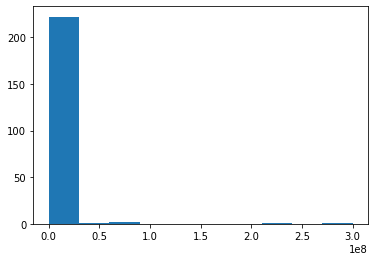

In [78]:
plt.hist(maize_df['Maize_Residue'].values)

(array([189.,  28.,   4.,   0.,   2.,   1.,   2.,   0.,   0.,   1.]),
 array([-5.30615371e+06,  8.73970377e+06,  2.27855613e+07,  3.68314187e+07,
         5.08772762e+07,  6.49231337e+07,  7.89689912e+07,  9.30148487e+07,
         1.07060706e+08,  1.21106564e+08,  1.35152421e+08]),
 <a list of 10 Patch objects>)

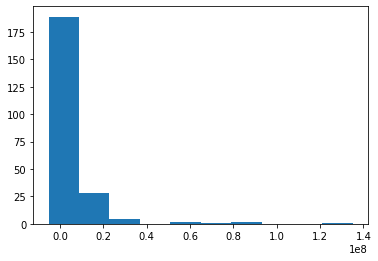

In [79]:
plt.hist(lm_pre_y.values)

In [80]:
from sklearn.metrics import mean_squared_error as mse
mse(y, spat_err.predy.flatten())

435653100690812.5

In [81]:
maize_dfg.head()

Maize_Residue  temperature_mean_Maize  temperature_max  \
0   8.793164e+04                  13.870            26.80   
1   3.224001e+05                  11.925            17.65   
2   3.414389e+03                  25.150            29.87   
3   1.582662e+05                  11.525            16.41   
4   6.768993e+06                  13.430            25.44   

   Maize_rainfall_mean  rainfall_max  rainfall_min  country_area  \
0               430.40       1558.70          4.30      652860.0   
1              1146.90       1683.50        981.50       28750.0   
2                59.40        987.70          9.10     2381741.0   
3              2319.60       3938.25       1912.05         200.0   
4               787.95       2493.05        452.90         470.0   

                                            geometry  
0  POLYGON ((74.54235 37.02167, 74.54742 37.01567...  
1  POLYGON ((20.56715 41.87318, 20.54172 41.86158...  
2  POLYGON ((6.58326 36.98981, 6.59946 36.97309, ...  
3  MULTIPOLYGON (((-170.59101 -14.26483, -170.576...  
4  POLYGON ((1.70701 42.50278, 1.69750 42.49446, ...

In [82]:
#projection for 2030
#add temperature change
maize_dfg["temperature_mean_Maize_2030"]=maize_dfg["temperature_mean_Maize"]+0.597
maize_dfg["temperature_max_2030"]=maize_dfg["temperature_max"]+0.597

In [83]:
maize_dfg.head()

Maize_Residue  temperature_mean_Maize  temperature_max  \
0   8.793164e+04                  13.870            26.80   
1   3.224001e+05                  11.925            17.65   
2   3.414389e+03                  25.150            29.87   
3   1.582662e+05                  11.525            16.41   
4   6.768993e+06                  13.430            25.44   

   Maize_rainfall_mean  rainfall_max  rainfall_min  country_area  \
0               430.40       1558.70          4.30      652860.0   
1              1146.90       1683.50        981.50       28750.0   
2                59.40        987.70          9.10     2381741.0   
3              2319.60       3938.25       1912.05         200.0   
4               787.95       2493.05        452.90         470.0   

                                            geometry  \
0  POLYGON ((74.54235 37.02167, 74.54742 37.01567...   
1  POLYGON ((20.56715 41.87318, 20.54172 41.86158...   
2  POLYGON ((6.58326 36.98981, 6.59946 36.97309, ...   
3  MULTIPOLYGON (((-170.59101 -14.26483, -170.576...   
4  POLYGON ((1.70701 42.50278, 1.69750 42.49446, ...   

   temperature_mean_Maize_2030  temperature_max_2030  
0                       14.467                27.397  
1                       12.522                18.247  
2                       25.747                30.467  
3                       12.122                17.007  
4                       14.027                26.037

In [84]:
X_2030=maize_dfg[["temperature_mean_Maize_2030","temperature_max_2030","Maize_rainfall_mean","rainfall_max","rainfall_min","country_area"]]
#X=maize_df[["country_area","rainfall_max",'Ferti_Value',"Land_Value"]]
#y_2030=maize_dfg[['Maize_Residue']]

In [85]:
y_pre_2030=lasso.predict(X_2030)
#y_pre_2030

In [86]:
for i in range(0,len(y_pre_2030)):
    if y_pre_2030[i]<0:
         y_pre_2030[i]=(-1)* y_pre_2030[i]
#y_pre_2030

In [87]:
maize_dfg["Maize_Residue_2030"]=y_pre_2030

Text(0.5, 1, 'Maize Residue Quantity (2030)')

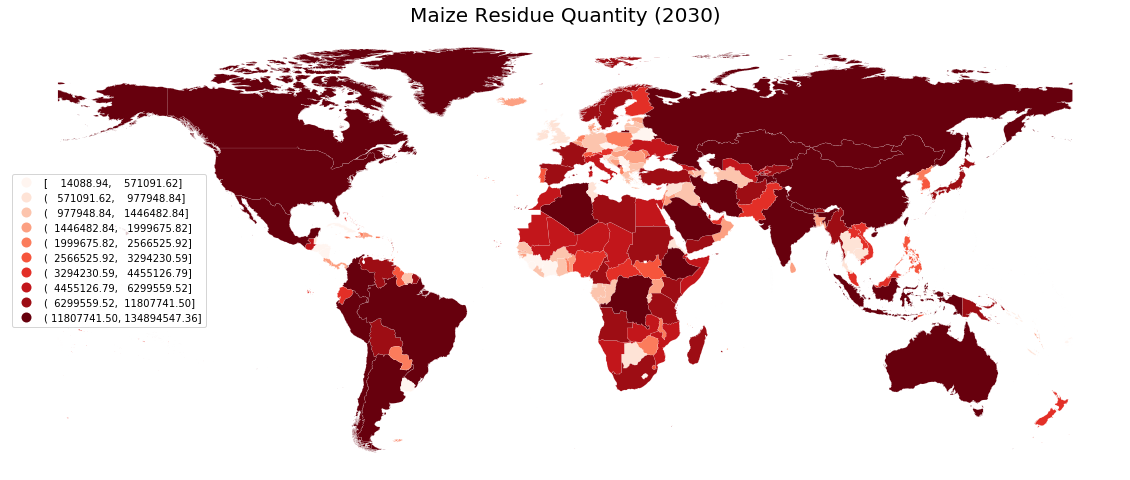

In [88]:
#visualize
fig, ax = plt.subplots(figsize=(20, 15))
#barley17_g.plot(column='barley_value', missing_kwds={'color': 'lightgrey'})
maize_dfg.plot(column='Maize_Residue_2030',scheme='quantiles',k=10, 
         cmap=plt.cm.Reds, alpha=1, legend=True,legend_kwds=dict(loc='center left'),
         edgecolor='w', linewidth=0.1,ax=ax,
               
       )
ax.set_axis_off()
ax.set_title("Maize Residue Quantity (2030)", fontsize=20)

In [89]:
#projection for 2040
#add temperature change
maize_dfg["temperature_mean_Maize_2040"]=maize_dfg["temperature_mean_Maize"]+0.851
maize_dfg["temperature_max_2040"]=maize_dfg["temperature_max"]+0.851

In [90]:
X_2040=maize_dfg[["temperature_mean_Maize_2040","temperature_max_2040","Maize_rainfall_mean","rainfall_max","rainfall_min","country_area"]]
#X=maize_df[["country_area","rainfall_max",'Ferti_Value',"Land_Value"]]
#y_2040=maize_dfg[['Maize_Residue']]

In [91]:
y_pre_2040=lasso.predict(X_2040)
#y_pre_2040

In [92]:
for i in range(0,len(y_pre_2040)):
    if y_pre_2040[i]<0:
         y_pre_2040[i]=(-1)* y_pre_2040[i]
#y_pre_2040

In [93]:
maize_dfg["Maize_Residue_2040"]=y_pre_2040

Text(0.5, 1, 'Maize Residue Quantity (2040)')

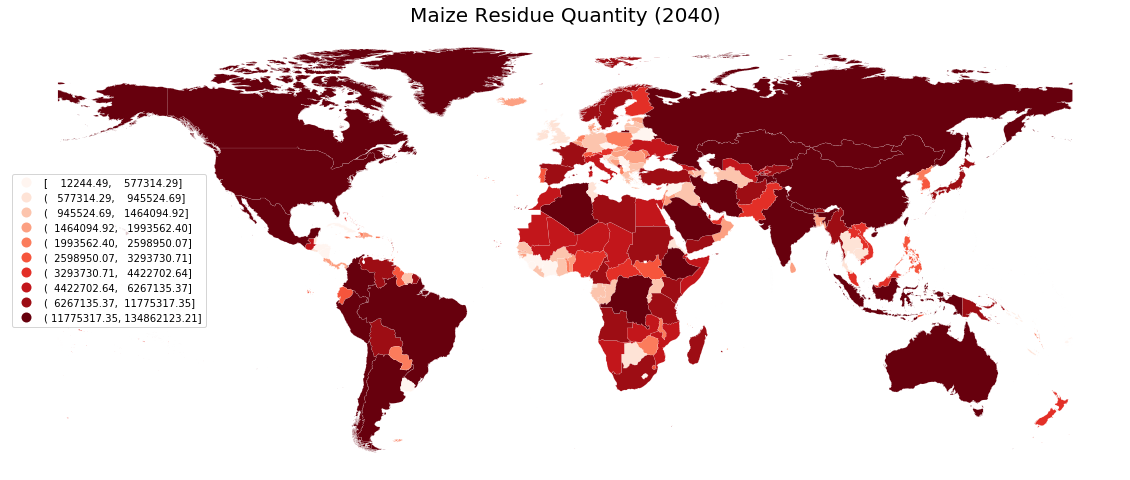

In [94]:
#visualize
fig, ax = plt.subplots(figsize=(20, 15))
#barley17_g.plot(column='barley_value', missing_kwds={'color': 'lightgrey'})
maize_dfg.plot(column='Maize_Residue_2040',scheme='quantiles',k=10, 
         cmap=plt.cm.Reds, alpha=1, legend=True,legend_kwds=dict(loc='center left'),
         edgecolor='w', linewidth=0.1,ax=ax,
               
       )
ax.set_axis_off()
ax.set_title("Maize Residue Quantity (2040)", fontsize=20)

In [95]:
#2030
#Cellulose
maize_dfg["Cellulose_2030"]=maize_dfg["Maize_Residue_2030"]*0.39
#Hemicellulose
maize_dfg["Hemicellulose_2030"]=maize_dfg["Maize_Residue_2030"]*0.27
#lignin
maize_dfg["Lignin_2030"]=maize_dfg["Maize_Residue_2030"]*0.33

In [96]:
#2030
#Cellulose
maize_dfg["Cellulose_2040"]=maize_dfg["Maize_Residue_2040"]*0.39
#Hemicellulose
maize_dfg["Hemicellulose_2040"]=maize_dfg["Maize_Residue_2040"]*0.27
#lignin
maize_dfg["Lignin_2040"]=maize_dfg["Maize_Residue_2040"]*0.33

In [97]:
maize_dfg["Country Code"]=maize18_g3['Country Code']

In [98]:
maize_dfg.to_csv("dataset/protein/maize_protein.csv",columns=["Cellulose_2030","Hemicellulose_2030","Lignin_2030",
                                                                 "Cellulose_2040","Hemicellulose_2040","Lignin_2040",
                                                                 "Country Code"])

In [99]:
diff_2030=maize_dfg["Maize_Residue_2030"]-maize_dfg["Maize_Residue"]

In [100]:
diff_2040=maize_dfg["Maize_Residue_2040"]-maize_dfg["Maize_Residue"]

In [101]:
diff_2040

0      1.142960e+07
1      2.128873e+06
2      1.455641e+07
3      2.723823e+06
4     -7.292925e+05
5      7.308447e+06
6      2.527742e+06
7      2.598885e+06
8     -1.120867e+07
9      1.751737e+06
10     3.199272e+05
11     5.187378e+07
12     1.815370e+06
13     7.450260e+05
14     3.857245e+06
15     5.148960e+06
16    -1.061185e+06
17     3.326395e+06
18    -5.745357e+05
19     1.615463e+06
20     6.962924e+05
21     4.018999e+05
22     2.498145e+06
23     1.013749e+07
24     8.337762e+06
25     8.895155e+05
26     7.460040e+05
27    -3.378377e+06
28     3.216783e+06
29    -8.940197e+06
30    -1.648825e+06
31    -6.264021e+04
32     9.652850e+05
33     5.091518e+06
34    -2.695767e+05
35     4.384653e+06
36     6.114574e+07
37     2.237751e+06
38     3.539629e+06
39     4.879655e+06
40     1.825795e+07
41    -1.310325e+08
42     1.615733e+06
43    -2.021083e+06
44     2.847883e+07
45     1.369694e+06
46     1.345307e+06
47     3.406026e+06
48     1.852328e+06
49    -4.325483e+05


In [102]:
#value in 2030 larger than the value in 2040
diff_2030 = np.array(diff_2030.values>0 ).sum()
diff_2030

177

In [103]:
diff_2040 = np.array(diff_2040.values>0 ).sum()
diff_2040

177